<a href="https://colab.research.google.com/github/Yunyaonate/coclear_segmentation/blob/main/Model_training_ipynb%EF%BC%88no_data_augmentation%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow
# !pip install tensorflow-gpu


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import tensorflow as tf
import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model

import glob
import os
import random
# from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
# import os

In [ ]:
print(tf.__version__)  # Ensure this is the GPU version
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load and preview the data

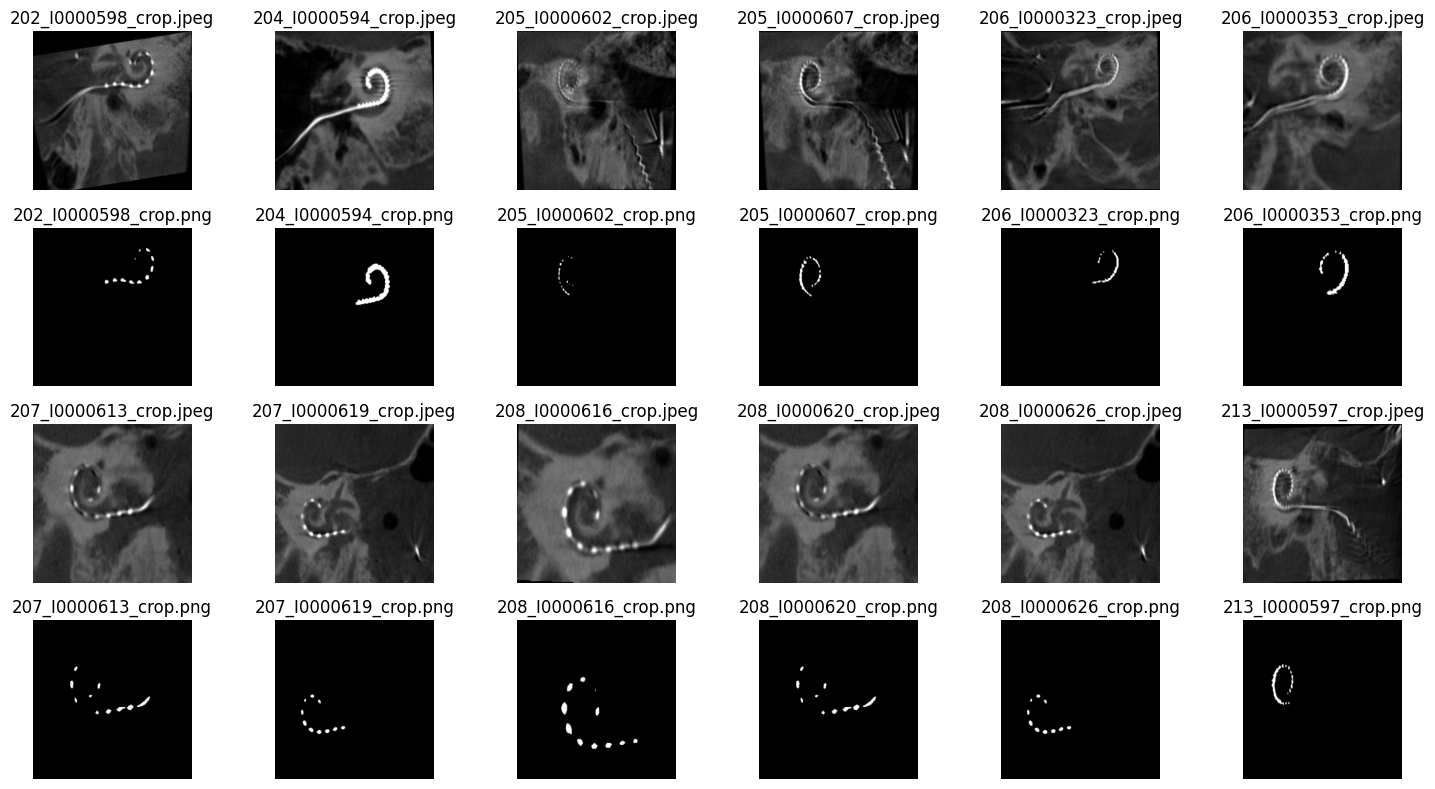

In [ ]:
# import matplotlib.pyplot as plt
# import cv2
# import os
# import glob

# Function to load images
def load_images_from_folder(folder, extension, num_images):
    return sorted(glob.glob(os.path.join(folder, f'*{extension}')))[:num_images]

# Define the paths to the directories and number of images
img_dir = '/content/drive/MyDrive/MDHDS/Capstone/Cato_A/img_dir'
ann_dir = '/content/drive/MyDrive/MDHDS/Capstone/Cato_A/ann_dir'
num_images = 12  # The number of images and masks to display

# Load the first 12 original images and masks
original_image_paths = load_images_from_folder(img_dir, '.jpeg', num_images)
mask_image_paths = [path.replace(img_dir, ann_dir).replace('.jpeg', '.png') for path in original_image_paths]

# Set up the matplotlib figure and axes
ncols = 6  # Number of columns (6 images per row)
nrows = 4  # Number of rows (4 rows for original images and 4 rows for masks)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2 * nrows))  # Adjust the figure size as needed

# Display the images in the first 4 rows
for idx, img_path in enumerate(original_image_paths):
    row = idx // ncols  # Determine the row. Integer division floors the result
    col = idx % ncols   # Determine the column
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    axs[row * 2, col].imshow(img)  # Place the original image in every even row (0, 2, 4, ...)
    axs[row * 2, col].axis('off')  # Hide axes
    axs[row * 2, col].set_title(os.path.basename(img_path))  # Set the title as the file name

# Display the masks in the second 4 rows (rows 1, 3, 5, and 7)
for idx, mask_path in enumerate(mask_image_paths):
    row = idx // ncols  # Determine the row. Integer division floors the result
    col = idx % ncols   # Determine the column
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read the mask
    axs[row * 2 + 1, col].imshow(mask, cmap='gray')  # Place the mask image in every odd row (1, 3, 5, ...)
    axs[row * 2 + 1, col].axis('off')  # Hide axes
    axs[row * 2 + 1, col].set_title(os.path.basename(mask_path))  # Set the title as the file name

plt.tight_layout()
plt.show()

# Check the path

In [ ]:
!ls /content/drive/MyDrive/MDHDS/Capstone/Cato_A

ann_dir  img_dir  mask	original  result


# Data Loader
## Spliting the images
  - Training : Validating : Testing = 8:1:1

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical
# import numpy as np
# import cv2
# import os

def load_data(img_dir, mask_dir, img_shape=(256, 256)):
    img_paths = sorted(glob.glob(os.path.join(img_dir, '*.jpeg')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')))

    images = [cv2.resize(cv2.imread(path), img_shape) for path in img_paths]
    masks = [cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), img_shape) for path in mask_paths]

    # Normalize images
    images = np.array(images).astype('float32') / 255.
    # Ensure masks are in the correct shape and type
    masks = np.array(masks).astype('float32') / 255.
    # Optionally threshold the masks to make sure they are binary
    masks = (masks > 0.5).astype('float32')

    # If necessary, expand the mask dimensions to match the image dimensions
    # Masks should have a shape of (num_samples, height, width, 1)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks

# Paths to your data directories
img_dir = '/content/drive/MyDrive/MDHDS/Capstone/Cato_A/img_dir'
mask_dir = '/content/drive/MyDrive/MDHDS/Capstone/Cato_A/ann_dir'


# Load your dataset
images, masks = load_data(img_dir, mask_dir)

# Split your dataset
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# # Create your data generators
# train_datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.05,
#     zoom_range=0.05,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator()

# # Note: You don't need to use .flow() methods if you've already loaded the data into memory
# train_generator = train_datagen.flow(x_train, y_train, batch_size=1)
# val_generator = val_datagen.flow(x_val, y_val, batch_size=1)

# Now, train_generator and val_generator can be used in your model.fit call
# Check the number of images in each set

print(f"Training images: {len(x_test)}, Validation images: {len(x_val)}, Testing images: {len(y_test)}")

Training images: 4, Validation images: 4, Testing images: 4


# U-Net Architecture

In [ ]:


def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Downsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Bottom
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    up1 = UpSampling2D(size=(2, 2))(conv2)

    # Upsample
    merge1 = concatenate([conv1, up1], axis=3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(merge1)

    # Output layer
    conv4 = Conv2D(1, 1, activation='sigmoid')(conv3)

    model = Model(inputs=inputs, outputs=conv4)

    return model


## IoU

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 128, 128, 128)        73856     ['max_pooling2d_2[0][0]'

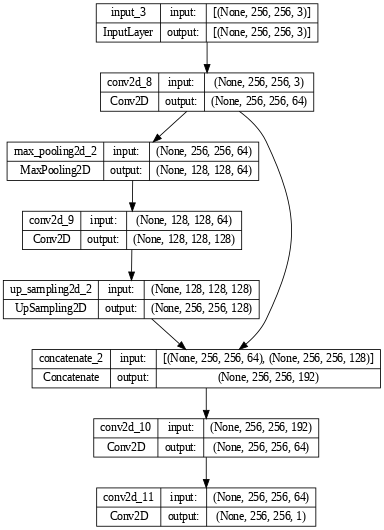

In [ ]:
from keras import backend as K

def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

unet_model = unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

# Print the model summary to check the architecture
unet_model.summary()

# Plotting the model
keras.utils.plot_model(unet_model, show_shapes=True, show_layer_names=True, dpi=60)

# Model Training

In [ ]:
checkpoint_path = '/content/drive/MyDrive/MDHDS/Capstone/Model/u_net_model.h5'

# Defining ModelCheckpoint callback to save the best weights
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Defining EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# ,callbacks=[checkpoint_callback, early_stopping]

# Model and training details
model_name = "U-Net"
metric_name = "IoU"
batch_size = 2  # Assuming you used this batch size for training
epochs = 100      # Assuming you trained for this many epochs

history = unet_model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1,callbacks=[checkpoint_callback])

# Loading the best weights
unet_model.load_weights(checkpoint_path)

Epoch 1/100
13/14 [==========================>...] - ETA: 0s - loss: 0.2765 - iou: 0.0346
Epoch 1: val_loss improved from inf to 0.19664, saving model to /content/drive/MyDrive/MDHDS/Capstone/Model/u_net_model.h5
14/14 [==============================] - 2s 68ms/step - loss: 0.2755 - iou: 0.0416 - val_loss: 0.1966 - val_iou: 0.0999
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 0.1401 - iou: 0.0722
Epoch 2: val_loss improved from 0.19664 to 0.08005, saving model to /content/drive/MyDrive/MDHDS/Capstone/Model/u_net_model.h5
14/14 [==============================] - 0s 33ms/step - loss: 0.1362 - iou: 0.0713 - val_loss: 0.0801 - val_iou: 0.0609
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0599 - iou: 0.1031
Epoch 3: val_loss improved from 0.08005 to 0.04213, saving model to /content/drive/MyDrive/MDHDS/Capstone/Model/u_net_model.h5
14/14 [==============================] - 0s 32ms/step - loss: 0.0589 - iou: 0.1058 - val_loss: 0.0421 - val_iou: 

In [ ]:
test_iou = unet_model.evaluate(x_test, y_test, verbose=1)
print('IoU on the test set:', test_iou[1])


1/1 [==============================] - 0s 48ms/step - loss: 0.0077 - iou: 0.5267
IoU on the test set: 0.5267494916915894


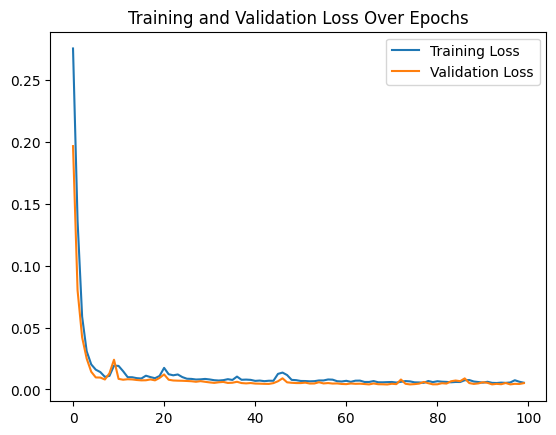

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Build the title with model details
descriptive_title = f'{model_name}_{metric_name}_BS{batch_size}_Epochs{epochs}_TraingValidation.png'

# Save the figure
# plt.savefig(f'/content/drive/MyDrive/MDHDS/Capstone/Cato_A/result/{descriptive_title}')
plt.show()

# Model Evaluation

In [ ]:
test_loss, test_accuracy = unet_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


1/1 [==============================] - 0s 51ms/step - loss: 0.0077 - iou: 0.5267
Test Loss: 0.007728908210992813, Test Accuracy: 0.5267494916915894


# Display the result

1/1 [==============================] - 0s 87ms/step


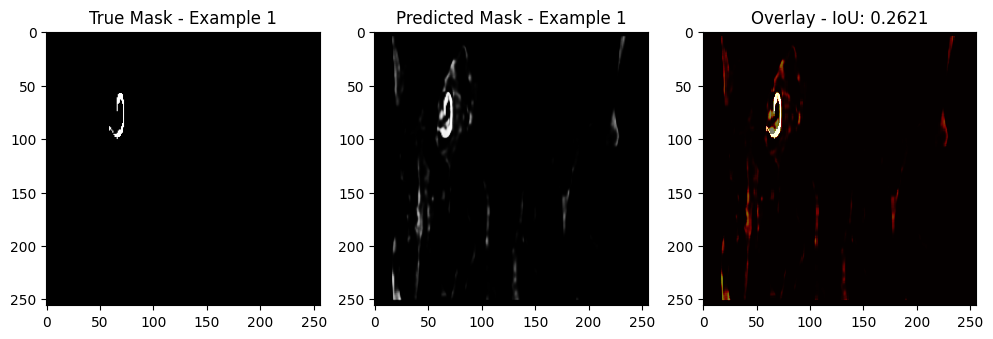

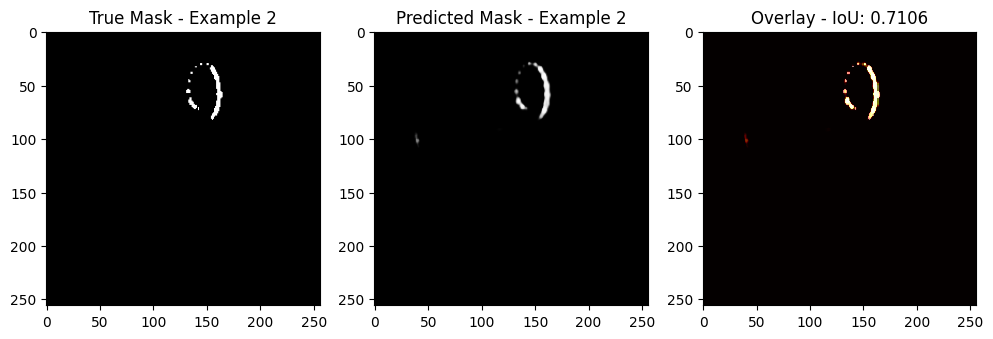

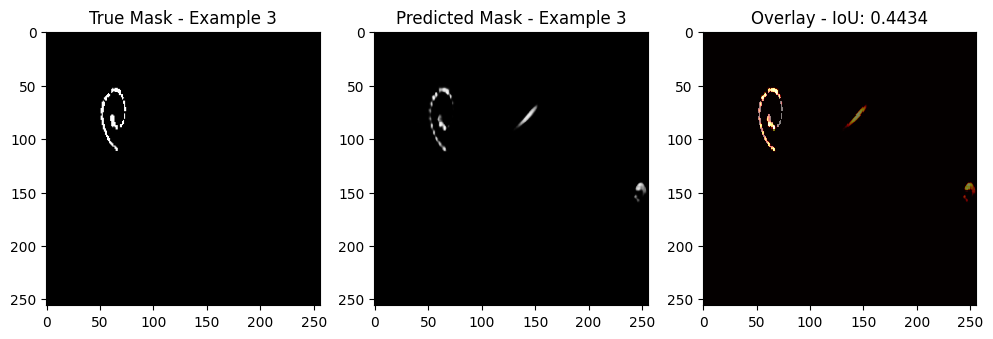

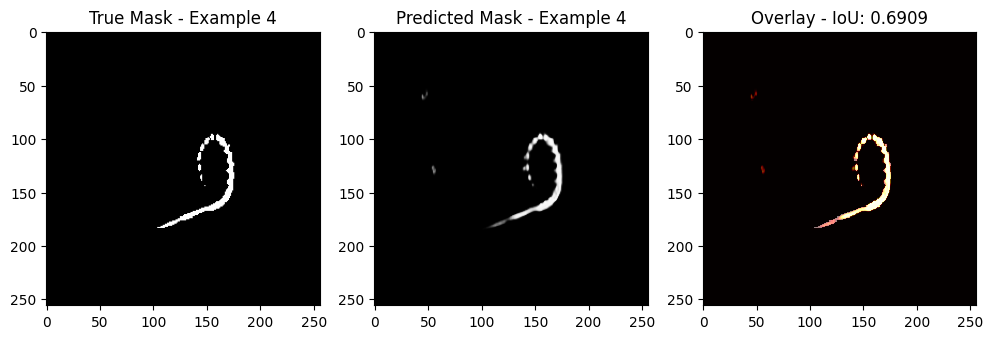

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # Model and training details
# model_name = "U-Net"
# metric_name = "IoU"
# batch_size = 1  # Assuming you used this batch size for training
# epochs = 100      # Assuming you trained for this many epochs

# Predict on test set
predictions = unet_model.predict(x_test)

# Calculate individual IoU for a few samples
for i in range(4):  # Just the first 4 examples
    true_mask = y_test[i]
    predicted_mask = predictions[i]
    current_iou = iou(np.expand_dims(true_mask, 0), np.expand_dims(predicted_mask, 0))

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.title(f'True Mask - Example {i+1}')
    plt.imshow(true_mask, cmap='gray')
    plt.subplot(132)
    plt.title(f'Predicted Mask - Example {i+1}')
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.subplot(133)
    plt.title(f'Overlay - IoU: {current_iou:.4f}')
    plt.imshow(true_mask, cmap='gray', interpolation='none')
    plt.imshow(predicted_mask.squeeze(), alpha=0.5, cmap='hot', interpolation='none')

    # Build the title with model details
    descriptive_title = f'{model_name}_{metric_name}_BS{batch_size}_Epochs{epochs}_Sample{i+1}.png'

    # Save the figure
    # plt.savefig(f'/content/drive/MyDrive/MDHDS/Capstone/Cato_A/result/{descriptive_title}')
    plt.show()


In [ ]:
# # Check of masks
# print(true_masks.shape)
# print(predicted_masks.shape)
# print(true_mask_binary.shape)
# print(predicted_mask_binary.shape)

In [ ]:
# from tensorflow.keras import backend as K

# # This resets the Keras backend, effectively clearing all model-related memory.
# K.clear_session()

